In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob
from subprocess import check_call

import numpy as np
import dask
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cmocean

import pop_tools

import util

In [3]:
def setenv():
    """Function to set environment variables, specifically on dask workers

    Usage:
      dask.run(setenv)
    """
    os.environ['CARTOPY_USER_BACKGROUNDS'] = '/glade/work/mclong/cartopy-background-img/'

setenv()

In [4]:
cluster, client = util.get_ClusterClient(memory='12GB')
cluster.scale(64)
client.run(setenv)
client

/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.58:40995,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
dsg = pop_tools.get_grid('POP_tx0.1v3')[['TLONG', 'TLAT']]
dsg

<xarray.Dataset> Size: 138MB
Dimensions:  (nlat: 2400, nlon: 3600)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLONG    (nlat, nlon) float64 69MB 250.0 250.2 250.2 ... 250.0 250.0 250.0
    TLAT     (nlat, nlon) float64 69MB -78.47 -78.47 -78.47 ... 62.34 62.34
Attributes:
    lateral_dims:       [2400, 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v3/grid/horiz_grid_200709.ieeer8
    topography_fname:   inputdata/ocn/pop/tx0.1v3/grid/topography_20170718.ie...
    region_mask_fname:  inputdata/ocn/pop/tx0.1v3/grid/region_mask_20170718.i...
    type:               tripole
    title:              POP_tx0.1v3 grid

In [6]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
dird = f'/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/{case}/ocn/proc/tseries/day_1'
files = sorted(glob(f'{dird}/{case}.pop.h.nday1.FG_CO2_2.????????-????????.nc'))
assert len(files)

In [7]:
# find start date for movive
start_date = '19800102-19810101'
datestr = [f.split('.')[-2] for f in files]
ndx0 = datestr.index(start_date)
files[ndx0]

'/glade/campaign/collections/cmip/CMIP6/CESM-HR/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/ocn/proc/tseries/day_1/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.19800102-19810101.nc'

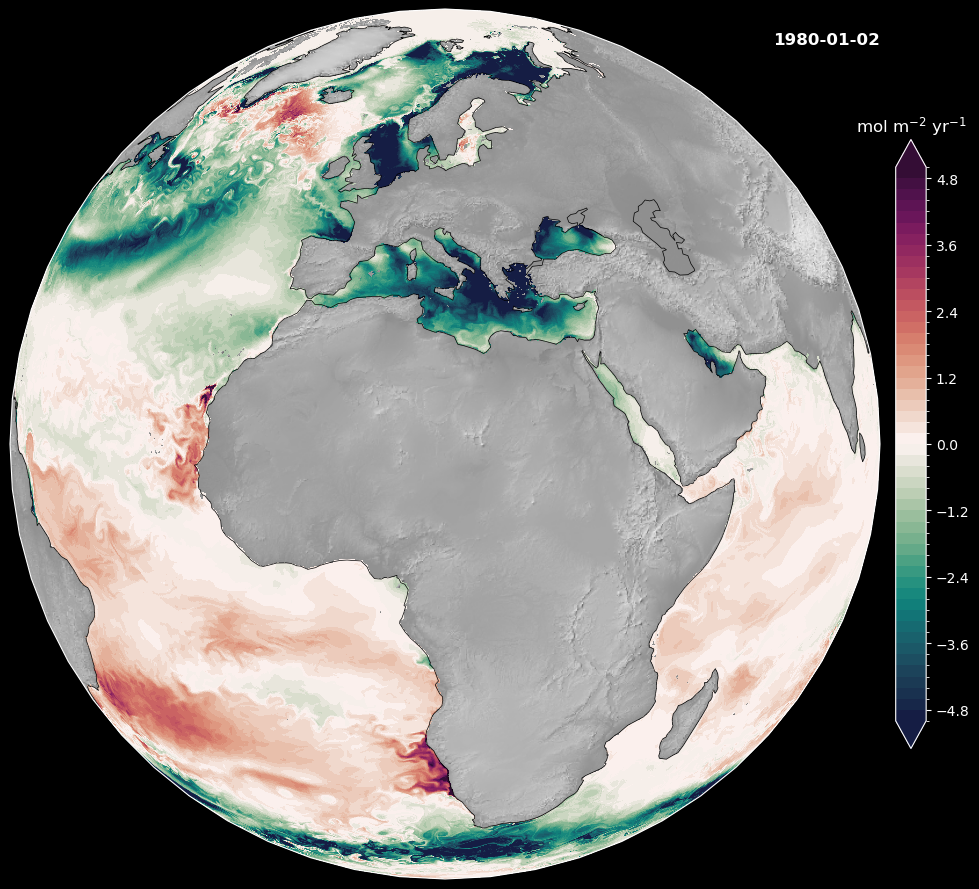

In [8]:
nmolcm2s_to_molm2yr = 1e4 * 1e-9 * 86400.0 * 365.0

with xr.open_dataset(files[ndx0]) as ds:
    fgco2 = ds.FG_CO2_2.isel(time=0).load()
    fgco2 *= nmolcm2s_to_molm2yr * -1.0
    fgco2.attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'


def plot_frame(fgco2_loc, time_level_movie, central_longitude=200, diro=None, topography='gray'):
    """Make a single frame of a movie of FG_CO2

    Args:

      fgco2 (xarray.DataArray) : 
        A timeslice of air-sea CO2 flux field

      time_level_movie (int) : 
        integer index into `time`

      diro (path, optional) : 
        Directory to put the movie frames.

      topography (str, optional) : 
        Selector for topography options

    """

    assert topography in ['color', 'gray', None], f'Unknown topography option: {topography}'

    #fgco2_loc = fgco2.isel(time=time_index_array)
    
    plt.style.use("dark_background")
    prj = ccrs.NearsidePerspective(
        central_longitude=central_longitude,
        central_latitude=20,
        false_easting=0, 
        false_northing=0, 
        globe=None)

    cmap = cmocean.cm.curl
    levels = np.arange(-5.0, 5.2, 0.2)

    fig, ax = plt.subplots(
        figsize=(12, 12),
        facecolor='k',
        subplot_kw=dict(projection=prj),
    )

    # put a background image
    # note: the data for these is accessible via setting an environment variable above
    # os.environ['CARTOPY_USER_BACKGROUNDS'] = '/glade/work/mclong/cartopy-background-img/'  
    # MCL: Not sure this is working with dask. I tried client.run(setenv)
    #      but it didn't work so I copied the images into the cartopy instll directory
    if topography == 'color':
        ax.background_img('natural-earth-1-no-ocean', resolution='large4096px')
    elif topography == 'gray':
        ax.background_img('gray-earth-no-ocean', resolution='large4096px')
    
    ax.coastlines(linewidth=0.5)

    pc = ax.pcolormesh(
        dsg.TLONG, dsg.TLAT, fgco2_loc, 
        cmap=cmap,
        norm=colors.BoundaryNorm(levels, ncolors=cmap.N),
        transform=ccrs.PlateCarree(),
    )

    if topography is None:
        land = ax.add_feature(
             cartopy.feature.NaturalEarthFeature(
                 'physical','land','110m',
                 edgecolor='face',
                 facecolor='lightgrey'
             )
        )

    cb = fig.colorbar(pc, shrink=0.7, extend='both', pad=0.01)
    cb.ax.set_title('mol m$^{-2}$ yr$^{-1}$', y=1.05, color='w')

    ax.set_title(
        fgco2_loc.time.values.item().strftime('%Y-%m-%d'), 
        loc='right', y=0.95, fontweight='bold', color='w')

    fig_size = (16, 9)
    fig.set_size_inches(fig_size)
    fig.tight_layout()

    if diro is not None:
        fig.savefig(f'{diro}/{time_level_movie:04d}.png', dpi=300)
        plt.close()

plot_frame(fgco2, 1, central_longitude=14.0)

In [ ]:
%%time
USER = os.environ['USER']
diro = f'/glade/work/{USER}/fgco2-frames/png'
check_call(['rm', '-fr', diro])
os.makedirs(diro, exist_ok=True)

def increment_longitude(lon_in, inc=4.0):
    """Return a valide longitude incremented by `inc`"""
    lon_out = lon_in + inc
    if lon_out > 360.0:
        lon_out -= 360.0
    return lon_out

n = 0
central_longitude = 180.0
for f in files[ndx0:]: 
    
    with xr.open_dataset(f, chunks={'time': 1}) as ds:
        fgco2 = ds.FG_CO2_2
        fgco2 *= nmolcm2s_to_molm2yr * -1.0
        fgco2 = fgco2.persist() # scatter to workers
        
    print(f'starting time loop: {os.path.basename(f)}')
    
    del_objs = []   
    for i in range(ds.sizes['time']):
        del_objs.append(
            dask.delayed(plot_frame)(
            fgco2.isel(time=i), 
            n, 
            diro=diro,
            central_longitude=central_longitude,
            )
        )
        n += 1
        central_longitude = increment_longitude(central_longitude)
    computed_objs = dask.compute(*del_objs)

starting time loop: g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.19800102-19810101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 132.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


starting time loop: g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.19810102-19820101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 132.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


starting time loop: g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.19820102-19830101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 132.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


starting time loop: g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.19830102-19840101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 132.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


starting time loop: g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001.pop.h.nday1.FG_CO2_2.19840102-19850101.nc


/glade/work/mclong/miniconda3/envs/mcdr-atlas/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 132.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
del client
del cluster

In [ ]:
%%bash

MOVOUT=/glade/work/${USER}/fgco2-frames/fgco2.mp4
FPS=12
ffmpeg_cmd="ffmpeg -y -start_number 1 -r ${FPS} -i /glade/work/${USER}/fgco2-frames/png/%04d.png"
ffmpeg_cmd="${ffmpeg_cmd} -c:v libx264 -pix_fmt yuv420p "
ffmpeg_cmd=${ffmpeg_cmd}' -vf "scale=1440:trunc(ow/a/2)*2" -movflags faststart'

cmd="${ffmpeg_cmd} ${MOVOUT} ;"
echo ${cmd}
eval ${cmd}